In [1]:
!python --version

Python 3.8.8


Install rdkit

In [2]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit


'wget' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


^C
The system cannot accept the time entered.
Enter the new time: 


Append RDKit path and import packages

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import RDConfig
from rdkit import rdBase
from rdkit.Chem.Draw import IPythonConsole

In [ ]:
rdBase.rdkitVersion

'2019.03.2'

LOAD data

In [ ]:
trainsdf = Chem.SDMolSupplier(os.path.join( RDConfig.RDDocsDir, 'Book/data/solubility.train.sdf'))
testsdf = Chem.SDMolSupplier(os.path.join( RDConfig.RDDocsDir, 'Book/data/solubility.test.sdf'))
train_mols = [mol for mol in trainsdf if mol != None]
test_mols = [mol for mol in testsdf if mol != None]
print(len(train_mols), len(test_mols))

sol_class = {"(A) low":0, "(B) medium":1, "(C) high": 2}

1025 257


In [ ]:
# 2048 bit vector
def mol2arr(mol):
  arr = np.zeros((1,))
  fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
  DataStructs.ConvertToNumpyArray(fp, arr)
  return arr

import tensorflow and use keras

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.layers import Activation, Dense, Dropout, Input
from keras.utils import np_utils


trainX = np.array([mol2arr(mol) for mol in train_mols])
trainY = [sol_class[mol.GetProp("SOL_classification")] for mol in train_mols]
trainY = np_utils.to_categorical(trainY)

testX = np.array([mol2arr(mol) for mol in test_mols])
testY = [sol_class[mol.GetProp("SOL_classification")] for mol in test_mols]
testY = np_utils.to_categorical(testY)


Using TensorFlow backend.


In [ ]:
inputs = Input(shape=(2048,), name='input')
x = Dense(100, activation='relu', name='Layer1')(inputs)
x = Dense(20, activation='relu', name='Layer2')(x)
x = Dense(2, activation='relu', name='Layer3')(x)
predictions = Dense(3, activation='softmax', name='output')(x)

model = Model(inputs=inputs, outputs = predictions)
model.compile(optimizer=tf.train.RMSPropOptimizer(0.001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
model.summary()


model_int = Model(inputs=inputs, outputs=model.get_layer(name='Layer3').output)
model_int.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
Layer1 (Dense)               (None, 100)               204900    
_________________________________________________________________
Layer2 (Dense)               (None, 20)                2020      
_________________________________________________________________
Layer3 (Dense)               (None, 2)                 42        
_________________________________________________________________
output (Dense)               (None, 3)                 9         
Total params: 206,971
Trainable params: 206,971
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inpu

In [ ]:
epochs = 50
hist = model.fit(np.array(trainX), trainY, batch_size=32, epochs=epochs)

Epoch 1/50
1025/1025 [==============================] - 0s 255us/step - loss: 1.0976 - acc: 0.3376
Epoch 2/50
1025/1025 [==============================] - 0s 96us/step - loss: 1.0933 - acc: 0.4088
Epoch 3/50
1025/1025 [==============================] - 0s 101us/step - loss: 1.0672 - acc: 0.4400
Epoch 4/50
1025/1025 [==============================] - 0s 96us/step - loss: 0.9741 - acc: 0.4351
Epoch 5/50
1025/1025 [==============================] - 0s 92us/step - loss: 0.8645 - acc: 0.5298
Epoch 6/50
1025/1025 [==============================] - 0s 96us/step - loss: 0.7702 - acc: 0.6156
Epoch 7/50
1025/1025 [==============================] - 0s 98us/step - loss: 0.6763 - acc: 0.6712
Epoch 8/50
1025/1025 [==============================] - 0s 97us/step - loss: 0.5821 - acc: 0.7385
Epoch 9/50
1025/1025 [==============================] - 0s 94us/step - loss: 0.4873 - acc: 0.8137
Epoch 10/50
1025/1025 [==============================] - 0s 94us/step - loss: 0.3978 - acc: 0.8420
Epoch 11/50
1025/

maybe 50 epochs is too mutch

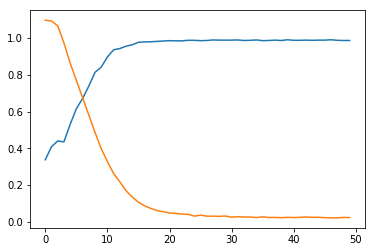

In [ ]:
plt.plot(range(epochs), hist.history['acc'])
plt.plot(range(epochs), hist.history['loss'])

In [ ]:
from sklearn.metrics import classification_report
predY = model.predict(testX)
predY = [np.argmax(y) for y in predY]
Y = [np.argmax(y) for y in testY]
print(classification_report(Y, predY))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75       102
           1       0.63      0.68      0.65       115
           2       0.56      0.60      0.58        40

    accuracy                           0.68       257
   macro avg       0.66      0.66      0.66       257
weighted avg       0.69      0.68      0.68       257



In [ ]:
intdata = model_int.predict(testX)
colormap = {0:"red", 1:"blue", 2:"green"}
c = [colormap[i] for i in Y]

In [ ]:
intdata[:,0].shape

(257,)

ValueError: ignored

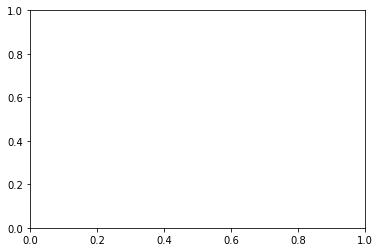

In [ ]:
plt.scatter(intdata.argmax, testY, c=c)